In [35]:
%run GraphFamilies.ipynb
from IPython.display import clear_output

In [66]:
# Get list of graphs from graph families

#SETTINGS:
# Higher settings will increase accuracy but result in slower runtime

# Maximum size hole to include
maxhole = 6

# Maximum length path to include
maxpath = 3

# TRUE: Use connected graph families
# FALSE: Use disconnected graph familise
connected = True 

#############
graph_family_list = AllFamilies(maxhole, maxpath, connected)
print(f"{len(graph_family_list)} graphs included for testing")

246 graphs included for testing


In [67]:
# Build full table of all induced subgraphs in list of graphs in the following form:
# Column 1: Graph
# Column 2: Full list of induced subgraphs of this graph
# Table is stored as a list of tuples

def build_graph_table():
    graph_table = []

    # Iterate each graph
    for G in graph_family_list:
        clear_output(wait=True)
        print(f"Progress: Graph {graph_family_list.index(G)+1}")
        G_sg_list = []

        # Iterate each induced subgraph of G
        for vertex_subset in Subsets(G.vertices()):
            current_sg = G.subgraph(vertex_subset)

            add_flag = True
            for H in G_sg_list:
                if (current_sg.order() != H.order()) or (current_sg.size() != H.size()): #Different number of vertices/edges, no need to test isomorphism
                    continue
                elif H.is_isomorphic(current_sg):
                    add_flag = False
                    break 
            
            if add_flag == True:
                G_sg_list.append(current_sg)
        
        graph_table.append((G, G_sg_list))
    
    return graph_table

graph_table_default = build_graph_table()


Progress: Graph 246


In [68]:
# Helper functions

def get_best_sgs(exclusions=[]):
    # Need only to test graphs know contained in graph with the least subgraphs
    # Find this graph
    best_no_subgraphs = 1000000
    for i in graph_table:
        current_no_subgraphs = len(i[1])
        if current_no_subgraphs < best_no_subgraphs:
            best_no_subgraphs = current_no_subgraphs
            best_graph_row = i
    
    return best_graph_row

In [69]:
# Find classification for single induced subgraph

def find_forbidden_1(graph_table = graph_table_default,exclusions=[]):
    forbidden_graphs = []
    test_sg_list = get_best_sgs()[1]
    
    # Order list of subgraphs we need to test by most vertices first
    test_sg_list.sort(reverse = True, key=order)

    # Check each 
    for test_sg in test_sg_list:
        add_flag = True

        # Make sure graph isn't excluded
        for exlusion in exclusions:
            if exlusion.subgraph_search(test_sg, induced=True) is not None:
                add_flag = False
                break
        if add_flag == False: continue

        # Make sure subgraph isn't already contained in a graph already included (most vertices first means this test is simple)
        for already_seen in forbidden_graphs:
            if already_seen.subgraph_search(test_sg, induced=True) is not None:
                add_flag = False
                break
        if add_flag == False: continue

        # Look at each graph in each family
        for current_graph in graph_table:
            good_flag = False

            # Check if the subgraph we're testing appears as a subgraph in this graph
            for current_sg in current_graph[1]:
                if (current_sg.order() != test_sg.order()) or (current_sg.size() != test_sg.size()): #Different number of vertices/edges, no need to test isomorphism
                    continue
                elif test_sg.is_isomorphic(current_sg):
                    good_flag = True
                    break
            
            # If not, stop testing this subgraph and don't include it
            if good_flag == False:
                add_flag = False
                break
        
        # Include subgraph only if found as a subgraph in all graphs
        if add_flag == True:
            forbidden_graphs.append(test_sg)
    
    return(forbidden_graphs)


forbidden_graphs_1 = find_forbidden_1()

In [70]:
# Find classification for two induced subgraphs
def find_forbidden_2(graph_table = graph_table_default):
    forbidden_graph_pairs = []

    test_first_sg_list = get_best_sgs()[1]
    
    # Order list of subgraphs we need to test by most vertices first
    test_first_sg_list.sort(reverse = True, key=order)

    # Check each 
    for test_sg in test_first_sg_list:
        add_flag = True

        # Check that isn't in the monogenic case
        for case_1 in forbidden_graphs_1:
            if case_1.subgraph_search(test_sg, induced=True) is not None:
                add_flag = False
                break
        if add_flag == False: continue

        # Create a new table by removing all graphs containing our subgraph
        culled_graph_table = deepcopy(graph_table)
        for current_graph in graph_table:
            good_flag = False

            # Check if the subgraph we're testing appears as a subgraph in this graph
            for current_sg in current_graph[1]:
                if (current_sg.order() != test_sg.order()) or (current_sg.size() != test_sg.size()): #Different number of vertices/edges, no need to test isomorphism
                    continue
                elif test_sg.is_isomorphic(current_sg):
                    good_flag = True
                    break
            
            # If it does, remove it from our new table
            if good_flag == True:
                culled_graph_table.remove(current_graph)
        
        # Find single graphs which are in all graphs of this new table but not in the monogenic case
        second_graphs = find_forbidden_1(culled_graph_table,forbidden_graphs_1)

        # Add pairs
        for second_graph in second_graphs:
            forbidden_graph_pairs.append([test_sg,second_graph])
    
    # Simplify by removing redundant pairs
    for pair_1 in forbidden_graph_pairs:
        pair_1_index = forbidden_graph_pairs.index(pair_1)
        for pair_2 in forbidden_graph_pairs[pair_1_index+1:]:
            if (pair_1[0].subgraph_search(pair_2[0], induced=True) is not None) and (pair_1[1].subgraph_search(pair_2[1], induced=True) is not None) or \
               (pair_1[0].subgraph_search(pair_2[1], induced=True) is not None) and (pair_1[1].subgraph_search(pair_2[0], induced=True) is not None):
                forbidden_graph_pairs.remove(pair_2)

    return forbidden_graph_pairs

forbidden_graphs_2 = find_forbidden_2()
    

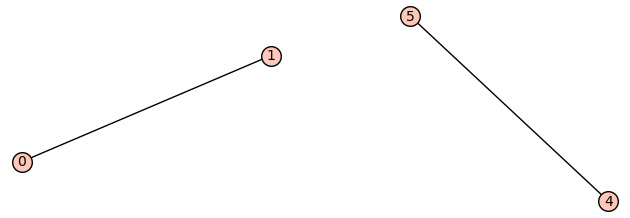

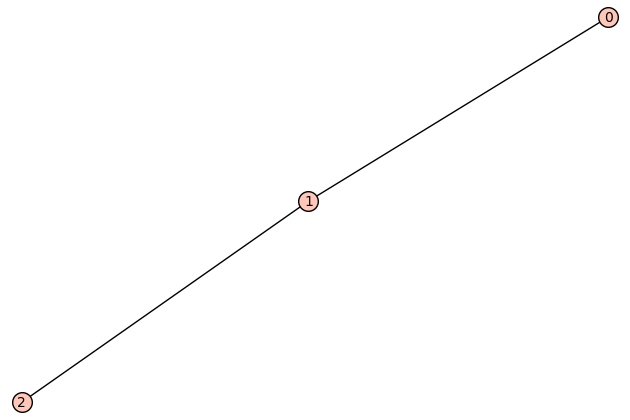

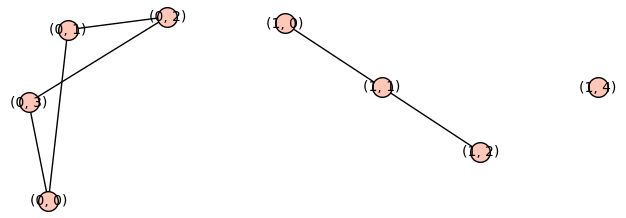

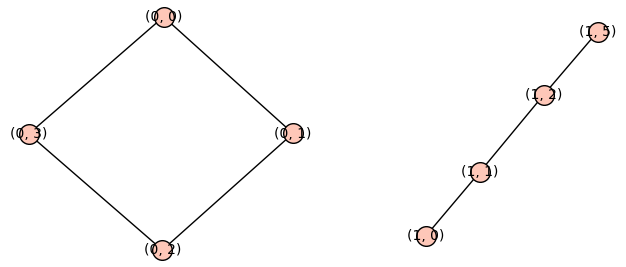

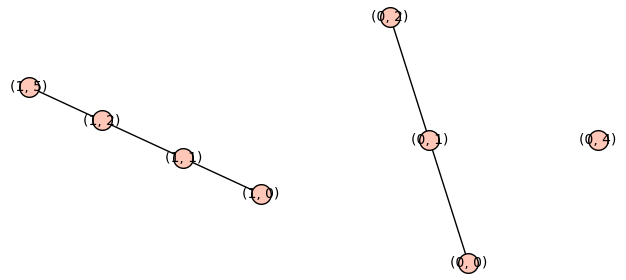

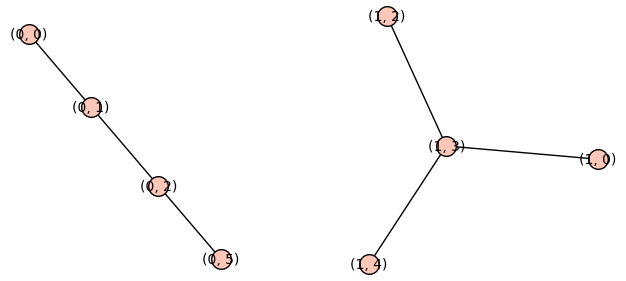

In [71]:
for i in forbidden_graphs_1:
    i.plot().show()

for i in forbidden_graphs_2:
    G = i[0].disjoint_union(i[1])
    G.plot().show()